In [1]:
from __future__ import print_function
import zipfile
import os

import torchvision.transforms as transforms
import argparse
from tqdm import tqdm
import os
import PIL.Image as Image

import torch

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import easydict

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,1), 'MB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**2,1), 'MB')

Using device: cuda

GeForce GTX 1070
Memory Usage:
Allocated: 0.0 MB
Cached:    0.0 MB


In [3]:
def initialize_data(folder):
    train_zip = folder + '/train_images.zip'
    test_zip = folder + '/test_images.zip'
    if not os.path.exists(train_zip) or not os.path.exists(test_zip):
        raise(RuntimeError("Could not find " + train_zip + " and " + test_zip
              + ', please download them from https://www.kaggle.com/c/nyu-cv-fall-2018/data '))
    # extract train_data.zip to train_data
    train_folder = folder + '/train_images'
    if not os.path.isdir(train_folder):
        print(train_folder + ' not found, extracting ' + train_zip)
        zip_ref = zipfile.ZipFile(train_zip, 'r')
        zip_ref.extractall(folder)
        zip_ref.close()
    # extract test_data.zip to test_data
    test_folder = folder + '/test_images'
    if not os.path.isdir(test_folder):
        print(test_folder + ' not found, extracting ' + test_zip)
        zip_ref = zipfile.ZipFile(test_zip, 'r')
        zip_ref.extractall(folder)
        zip_ref.close()

    # make validation_data by using images 00000*, 00001* and 00002* in each class
    val_folder = folder + '/val_images'
    if not os.path.isdir(val_folder):
        print(val_folder + ' not found, making a validation set')
        os.mkdir(val_folder)
        for dirs in os.listdir(train_folder):
            if dirs.startswith('000'):
                os.mkdir(val_folder + '/' + dirs)
                for f in os.listdir(train_folder + '/' + dirs):
                    if f.startswith('00000') or f.startswith('00001') or f.startswith('00002'):
                        # move file to validation folder
                        os.rename(train_folder + '/' + dirs + '/' + f, val_folder + '/' + dirs + '/' + f)

In [4]:
address = 'D:/Sync/Courses/Level_3/CV/Courant-CSCI-2271-Computer-Vision/Assignment_2'
initialize_data(address)

In [5]:
data_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

In [6]:
address = 'C:/Users/tiany/Assignment_2'
initialize_data(address)

data_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

args = easydict.EasyDict({
    'batch_size': 100,
    'epochs':100,
    'lr':0.0001,
    'momentum':0.5,
    'seed':1,
    'log_interval':100,
    'weight_decay':1e-2
})

kwargs = {'num_workers': 12, 'pin_memory': True}

torch.manual_seed(args.seed)
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(address + '/train_images',
                         transform=data_transforms),
    batch_size=args.batch_size, shuffle=True, **kwargs)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(address + '/val_images',
                         transform=data_transforms),
    batch_size=args.batch_size, shuffle=False, **kwargs)

In [7]:
nclasses = 43
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 100, kernel_size=3)
        self.conv2 = nn.Conv2d(100, 150, kernel_size=4)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(150, 250, kernel_size=3)
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1000, 200)
        self.fc2 = nn.Linear(200, nclasses)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = x.view(-1, 250*4)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
### Neural Network and Optimizer
# We define neural net in model.py so that it can be reused by the evaluate.py script
model = Net().to(device)
optimizer = optim.AdamW(model.parameters(), lr=args.lr,weight_decay=args.weight_decay)

In [9]:
import torchsummary
torchsummary.summary(model,input_size=(3,32,32))

c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 30, 30]           2,800
            Conv2d-2          [-1, 150, 12, 12]         240,150
         Dropout2d-3          [-1, 150, 12, 12]               0
            Conv2d-4            [-1, 250, 4, 4]         337,750
         Dropout2d-5            [-1, 250, 4, 4]               0
            Linear-6                  [-1, 200]         200,200
            Linear-7                   [-1, 43]           8,643
Total params: 789,543
Trainable params: 789,543
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.08
Params size (MB): 3.01
Estimated Total Size (MB): 4.10
----------------------------------------------------------------


In [10]:
def train(epoch):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        train_loss = F.cross_entropy(output,target).to(device)
        train_loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)# get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        training_accuracy = 100. * correct / len(train_loader.dataset)
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}/{} ({:.6f}%)'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss.item(),
                correct, len(train_loader.dataset), training_accuracy))

    return train_loss.item(), training_accuracy
def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        validation_loss += F.cross_entropy(output,target).to(device).item() # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)# get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(val_loader.dataset)
    validation_accuracy = 100. * correct / len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset), validation_accuracy))
    return validation_loss, validation_accuracy

In [12]:
training_loss_log = []
training_accuracy_log = []
validation_loss_log = []
validation_accuracy_log = []
best_acc = 0.0

for epoch in range(1, args.epochs + 1):
    training_loss, training_accuracy = train(epoch)
    validation_loss, validation_accuracy = validation() 
    
    training_loss_log.append(training_loss)
    training_accuracy_log.append(training_accuracy)
    validation_loss_log.append(validation_loss)
    validation_accuracy_log.append(validation_accuracy)
    
    if validation_accuracy > best_acc:
        best_acc = validation_accuracy
        torch.save(model.state_dict(), "model_Net_5_best.pth")

    torch.save(model.state_dict(), "model_Net_5_" + str(epoch) + ".pth")

c:\users\tiany\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/35339 (0%)]	Loss: 3.500224	Accuracy: 5/35339 (0.014149%)
Train Epoch: 1 [10000/35339 (28%)]	Loss: 3.256943	Accuracy: 996/35339 (2.818416%)
Train Epoch: 1 [20000/35339 (56%)]	Loss: 2.955888	Accuracy: 2573/35339 (7.280908%)
Train Epoch: 1 [30000/35339 (85%)]	Loss: 2.710732	Accuracy: 4853/35339 (13.732703%)

Validation set: Average loss: 0.034477, Accuracy: 647/3870 (16.718346%)

Train Epoch: 2 [0/35339 (0%)]	Loss: 2.434618	Accuracy: 32/35339 (0.090552%)
Train Epoch: 2 [10000/35339 (28%)]	Loss: 2.195299	Accuracy: 3529/35339 (9.986134%)
Train Epoch: 2 [20000/35339 (56%)]	Loss: 1.737124	Accuracy: 7717/35339 (21.837064%)
Train Epoch: 2 [30000/35339 (85%)]	Loss: 1.585825	Accuracy: 12426/35339 (35.162285%)

Validation set: Average loss: 0.024052, Accuracy: 1219/3870 (31.498708%)

Train Epoch: 3 [0/35339 (0%)]	Loss: 1.225501	Accuracy: 66/35339 (0.186763%)
Train Epoch: 3 [10000/35339 (28%)]	Loss: 1.447375	Accuracy: 5465/35339 (15.464501%)
Train Epoch: 3 [20000/35339 (56%)]	Loss

Train Epoch: 41 [0/35339 (0%)]	Loss: 0.073884	Accuracy: 97/35339 (0.274484%)
Train Epoch: 41 [10000/35339 (28%)]	Loss: 0.021440	Accuracy: 10033/35339 (28.390730%)
Train Epoch: 41 [20000/35339 (56%)]	Loss: 0.031771	Accuracy: 19972/35339 (56.515465%)
Train Epoch: 41 [30000/35339 (85%)]	Loss: 0.041443	Accuracy: 29898/35339 (84.603413%)

Validation set: Average loss: 0.001620, Accuracy: 3690/3870 (95.348837%)

Train Epoch: 42 [0/35339 (0%)]	Loss: 0.018094	Accuracy: 100/35339 (0.282973%)
Train Epoch: 42 [10000/35339 (28%)]	Loss: 0.023408	Accuracy: 10038/35339 (28.404878%)
Train Epoch: 42 [20000/35339 (56%)]	Loss: 0.050521	Accuracy: 19974/35339 (56.521124%)
Train Epoch: 42 [30000/35339 (85%)]	Loss: 0.099744	Accuracy: 29907/35339 (84.628880%)

Validation set: Average loss: 0.001764, Accuracy: 3703/3870 (95.684755%)

Train Epoch: 43 [0/35339 (0%)]	Loss: 0.013822	Accuracy: 100/35339 (0.282973%)
Train Epoch: 43 [10000/35339 (28%)]	Loss: 0.013351	Accuracy: 10036/35339 (28.399219%)
Train Epoch: 43


Train Epoch: 61 [0/35339 (0%)]	Loss: 0.019636	Accuracy: 99/35339 (0.280144%)
Train Epoch: 61 [10000/35339 (28%)]	Loss: 0.008406	Accuracy: 10056/35339 (28.455814%)
Train Epoch: 61 [20000/35339 (56%)]	Loss: 0.002452	Accuracy: 20012/35339 (56.628654%)
Train Epoch: 61 [30000/35339 (85%)]	Loss: 0.062290	Accuracy: 29976/35339 (84.824132%)

Validation set: Average loss: 0.001738, Accuracy: 3718/3870 (96.072351%)

Train Epoch: 62 [0/35339 (0%)]	Loss: 0.014273	Accuracy: 99/35339 (0.280144%)
Train Epoch: 62 [10000/35339 (28%)]	Loss: 0.009448	Accuracy: 10056/35339 (28.455814%)
Train Epoch: 62 [20000/35339 (56%)]	Loss: 0.009245	Accuracy: 20024/35339 (56.662611%)
Train Epoch: 62 [30000/35339 (85%)]	Loss: 0.005760	Accuracy: 29993/35339 (84.872237%)

Validation set: Average loss: 0.001951, Accuracy: 3705/3870 (95.736434%)

Train Epoch: 63 [0/35339 (0%)]	Loss: 0.007447	Accuracy: 100/35339 (0.282973%)
Train Epoch: 63 [10000/35339 (28%)]	Loss: 0.005277	Accuracy: 10058/35339 (28.461473%)
Train Epoch: 63


Train Epoch: 81 [0/35339 (0%)]	Loss: 0.059039	Accuracy: 98/35339 (0.277314%)
Train Epoch: 81 [10000/35339 (28%)]	Loss: 0.004265	Accuracy: 10076/35339 (28.512408%)
Train Epoch: 81 [20000/35339 (56%)]	Loss: 0.004791	Accuracy: 20052/35339 (56.741843%)
Train Epoch: 81 [30000/35339 (85%)]	Loss: 0.002541	Accuracy: 30022/35339 (84.954300%)

Validation set: Average loss: 0.001639, Accuracy: 3726/3870 (96.279070%)

Train Epoch: 82 [0/35339 (0%)]	Loss: 0.004750	Accuracy: 100/35339 (0.282973%)
Train Epoch: 82 [10000/35339 (28%)]	Loss: 0.000714	Accuracy: 10073/35339 (28.503919%)
Train Epoch: 82 [20000/35339 (56%)]	Loss: 0.049793	Accuracy: 20036/35339 (56.696568%)
Train Epoch: 82 [30000/35339 (85%)]	Loss: 0.007302	Accuracy: 30018/35339 (84.942981%)

Validation set: Average loss: 0.001451, Accuracy: 3726/3870 (96.279070%)

Train Epoch: 83 [0/35339 (0%)]	Loss: 0.001143	Accuracy: 100/35339 (0.282973%)
Train Epoch: 83 [10000/35339 (28%)]	Loss: 0.006169	Accuracy: 10073/35339 (28.503919%)
Train Epoch: 8

In [16]:
training_loss_log

[2.35703706741333,
 1.459616780281067,
 0.7817439436912537,
 0.6034301519393921,
 0.5136042833328247,
 0.3112473785877228,
 0.3255736529827118,
 0.16546334326267242,
 0.2771284282207489,
 0.27081361413002014,
 0.09266720712184906,
 0.04675436019897461,
 0.1129666194319725,
 0.06405391544103622,
 0.03172930330038071,
 0.34330514073371887,
 0.13505111634731293,
 0.06603546440601349,
 0.11529804766178131,
 0.3614964187145233,
 0.055012643337249756,
 0.036679647862911224,
 0.014437217265367508,
 0.059026606380939484,
 0.017712755128741264,
 0.026736078783869743,
 0.051045339554548264,
 0.007028455380350351,
 0.0065338267013430595,
 0.00696925725787878,
 0.1672004610300064,
 0.002641758183017373,
 0.09932450205087662,
 0.022602664306759834,
 0.014482088387012482,
 0.055322304368019104,
 0.004141081124544144,
 0.009789376519620419,
 0.032681919634342194,
 0.01677432842552662,
 0.02527850680053234,
 0.006948673631995916,
 0.000677490490488708,
 0.04134346544742584,
 0.00979691930115223,
 0.00

In [17]:
training_accuracy_log

[18.033900223549054,
 42.658252921701234,
 59.690427006989445,
 73.07507286567248,
 81.08322250205156,
 85.96451512493279,
 89.02345850193836,
 91.21367327881377,
 92.71626248620504,
 93.81419960949658,
 94.81875548261128,
 95.43563768074931,
 95.99026571210278,
 96.2732391974872,
 96.73731571351765,
 97.13064885820198,
 97.35136817680183,
 97.64000113189394,
 97.80695548827075,
 97.89750700359376,
 98.16633181470897,
 98.27952120886273,
 98.40685927728572,
 98.43515662582416,
 98.67285435354707,
 98.64738673986247,
 98.83414924021619,
 98.69549223237783,
 98.87942499787769,
 98.9247007555392,
 98.96997651320072,
 98.96997651320072,
 99.07184696793911,
 99.12844166501598,
 99.16522821811596,
 99.1935255666544,
 99.1737174226775,
 99.20767424092362,
 99.1737174226775,
 99.25577973343897,
 99.3406717790543,
 99.32935283963893,
 99.35765018817737,
 99.38877727156965,
 99.42556382466962,
 99.4425422337927,
 99.44820170350039,
 99.57836950677722,
 99.4425422337927,
 99.47649905203882,
 99.4

In [18]:
validation_loss_log

[0.03447743740500714,
 0.0240521098138134,
 0.015834252461213474,
 0.010721746736834216,
 0.008101607868279443,
 0.006069035510934446,
 0.004970446970188649,
 0.004675362360945274,
 0.0038261663299823992,
 0.0036091577509557706,
 0.0033739444701053993,
 0.0030832558546638844,
 0.0030240302144378924,
 0.0029055752012354034,
 0.0026726137528446255,
 0.002805984736773972,
 0.0026248316095241896,
 0.0023749370235758437,
 0.002258747883829305,
 0.0024036161050751555,
 0.002211025343348756,
 0.002254135277752767,
 0.0022146897391387256,
 0.002126114109280767,
 0.0020331547448161308,
 0.00199799515086302,
 0.0020077841097771165,
 0.002068029716516904,
 0.002013609104948323,
 0.0018572817961983166,
 0.001881329234854471,
 0.001793845287567481,
 0.0018683201098281864,
 0.0021154988014280016,
 0.0018233071774755995,
 0.001882786549937921,
 0.0018708895632414478,
 0.0017434350227250794,
 0.0016753545174458954,
 0.0016730391220438556,
 0.0016204925027812195,
 0.001763613121690847,
 0.0015572371516

In [19]:
validation_accuracy_log

[16.718346253229974,
 31.498708010335918,
 56.950904392764855,
 70.36175710594316,
 76.97674418604652,
 83.82428940568475,
 86.89922480620154,
 87.77777777777777,
 90.31007751937985,
 90.98191214470285,
 91.7312661498708,
 92.63565891472868,
 92.48062015503876,
 92.86821705426357,
 93.4625322997416,
 93.22997416020672,
 93.25581395348837,
 94.05684754521964,
 94.57364341085271,
 93.90180878552971,
 94.49612403100775,
 94.31524547803618,
 94.31524547803618,
 94.49612403100775,
 94.5219638242894,
 94.65116279069767,
 94.62532299741602,
 94.8062015503876,
 94.88372093023256,
 94.83204134366925,
 94.83204134366925,
 95.4780361757106,
 95.1937984496124,
 94.59948320413437,
 94.93540051679587,
 95.5297157622739,
 95.21963824289406,
 95.27131782945736,
 95.68475452196382,
 95.68475452196382,
 95.34883720930233,
 95.68475452196382,
 95.76227390180878,
 95.83979328165374,
 95.24547803617571,
 95.99483204134367,
 95.81395348837209,
 95.1937984496124,
 95.60723514211887,
 95.60723514211887,
 96.0

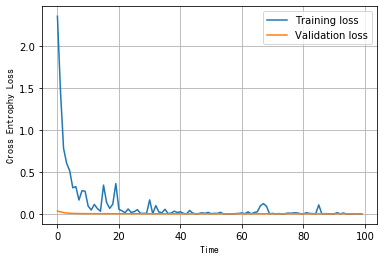

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
time = list(range(100))

plt.plot(time,training_loss_log)
plt.plot(time,validation_loss_log)
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.ylabel(u'Cross Entrophy Loss',fontproperties='SimHei')
plt.xlabel(u'Time',fontproperties='SimHei')

plt.grid(True)
plt.show()

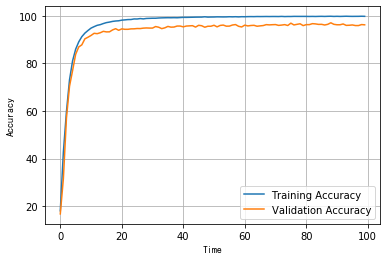

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
time = list(range(100))

plt.plot(time,training_accuracy_log)
plt.plot(time,validation_accuracy_log)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylabel(u'Accuracy',fontproperties='SimHei')
plt.xlabel(u'Time',fontproperties='SimHei')

plt.grid(True)
plt.show()

In [26]:
for i in range(len(validation_accuracy_log)):
    if validation_accuracy_log[i]>97:
        print(i+1)

89
